In [2]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = (400, 300)
IPythonConsole.drawOptions.addAtomIndices = False
import pandas as pd
from rdkit.Chem import PandasTools
import numpy as np

## Importing the data

In [3]:
fda_approved_drugs = pd.read_csv("/home/gustavo/github/mestrado/masters-project/main_project/data/fda_approved_datasets/fda_approved_drugs.csv")
fda_approved_drugs.head()

,name,chembl_id,clean_smiles,first_approval_year,indication_class,molecule_type,withdrawn_flag,therapeutic_flag,polymer_flag,inorganic_flag,natural_product_flag,oral,parenteral,topical
0,GUANIDINE HYDROCHLORIDE,CHEMBL1200728,N=C(N)N,1939,NaN,Small molecule,False,True,False,False,False,True,False,False
1,ACETOHYDROXAMIC ACID,CHEMBL734,CC(=O)NO,1983,Enzyme Inhibitor (urease),Small molecule,False,True,False,False,False,True,False,False
2,HYDROXYUREA,CHEMBL467,NC(=O)NO,1967,Antineoplastic,Small molecule,False,True,False,False,False,True,False,False
3,CYSTEAMINE,CHEMBL602,NCCS,1994,CYSTEAMINE HYDROCHLORIDE,Small molecule,False,True,False,False,False,True,False,True
4,DIMETHYL SULFOXIDE,CHEMBL504,C[S+](C)[O-],1978,Anti-Inflammatory (topical),Small molecule,False,True,False,False,False,False,True,False


In [4]:
# We will only select the smiles and name
drugs = fda_approved_drugs[['chembl_id', 'clean_smiles']]
drugs_smiles_list = list(drugs.clean_smiles)

## Definying the function for extracting rings

In [5]:
# Definying a function to get all the rings
def get_ring_atoms(mol, includeSpiro=False) -> list:
    """
    Return the atoms of all the rings present in the structure
    Can be used to retrieve the ring SMILES for ex.
    """
    ri = mol.GetRingInfo()
    systems = []
    
    # Function to get the atom index of rings present in the molecule
    for ring in ri.AtomRings():
        ringAts = set(ring)
        nSystems = []
        for system in systems:
            nInCommon = len(ringAts.intersection(system))
            if nInCommon and (includeSpiro or nInCommon>1):
                ringAts = ringAts.union(system)
            else:
                nSystems.append(system)
        nSystems.append(ringAts)
        systems = nSystems
    
    # This is a list of lists, maybe you'll need to flatten it for further analysis
    return [list(ring_idx) for ring_idx in systems] 

# Definying a function to get the ring SMILES of a structure
def get_substructure_smiles(smile) -> list:
    """
    Return all the SMILES substructure from the parent molecule
    """
    #transforming the entire structure from SMILES to mol
    mol = Chem.MolFromSmiles(smile)
    substructure_smiles = []

    for ring in get_ring_atoms(mol):
        substructure_smiles.append(Chem.MolFragmentToSmiles(mol, ring, canonical=True))
    return substructure_smiles

### Rings on the drugs

In [6]:
rings_on_drugs = []

for drug in drugs_smiles_list:
    rings_on_drugs.append(get_substructure_smiles(drug))

# This is a solution because it is a list of lists.
rings_smiles = list(np.concatenate(rings_on_drugs))

### Cleaning the rings SMILES

In [7]:
import requests
CACTUS_END = 'https://cactus.nci.nih.gov/chemical/structure/'

def smiles_from_cactus(SMILES) -> str:
    smiles_request =  f'{CACTUS_END}{SMILES}/smiles'
    response = requests.get(smiles_request)
    converted_smiles = response.text

    return converted_smiles

## First step

In [8]:
canon_smiles = []
dirty_smiles = []

# Then we check it if the ring_smile is problematic
for ring_smile in rings_smiles:
    if Chem.MolFromSmiles(ring_smile) is None:
        dirty_smiles.append(smiles_from_cactus(ring_smile))
    else:
        canon_smiles.append(Chem.MolToSmiles(Chem.MolFromSmiles(ring_smile)))

[14:27:47] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[14:27:47] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5
[14:27:47] Can't kekulize mol.  Unkekulized atoms: 0 1 3 5
[14:27:48] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7
[14:27:48] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5 7 8
[14:27:49] Can't kekulize mol.  Unkekulized atoms: 0 1 3 5
[14:27:49] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[14:27:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[14:27:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[14:27:51] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5
[14:27:51] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[14:27:52] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[14:27:52] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5
[14:27:52] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[14:27:53] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5
[14:27:53] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5 7 8 9 10 11 

In [9]:
print(f"This is how many non-problematic SMILES we have got: {len(canon_smiles)}")
print(f"This is how many PROBLEMATIC SMILES we still got: {len(dirty_smiles)}")
print(f"Basically we have {len(canon_smiles)/(len(canon_smiles)+len(dirty_smiles))*100:.2f}%")

This is how many non-problematic SMILES we have got: 3517
This is how many PROBLEMATIC SMILES we still got: 252
Basically we have 93.31%


## Second step

In [10]:
def inchi_backto_smiles(SMILES):
    CACTUS_END = 'https://cactus.nci.nih.gov/chemical/structure/'
    inch_request = f'{CACTUS_END}{SMILES}/stdinchi'
    response = requests.get(inch_request)
    inch = response.text

    smiles_request = f'{CACTUS_END}{inch}/smiles'
    response = requests.get(smiles_request)
    smiles_back = response.text
    return Chem.MolToSmiles(Chem.MolFromSmiles(smiles_back))


smiles_from_inchi = []
garbage = []

for ring_smile in dirty_smiles:
    try:
        smiles_from_inchi.append(Chem.MolToSmiles(Chem.MolFromSmiles(inchi_backto_smiles(ring_smile))))
    except:
        garbage.append(ring_smile)

print(f"We have got {len(dirty_smiles)}, and after the cleaning we're left with {len(smiles_from_inchi)}")

[14:29:46] SMILES Parse Error: syntax error while parsing: <h1>Page
[14:29:46] SMILES Parse Error: Failed parsing SMILES '<h1>Page' for input: '<h1>Page'
[14:29:47] SMILES Parse Error: syntax error while parsing: <h1>Page
[14:29:47] SMILES Parse Error: Failed parsing SMILES '<h1>Page' for input: '<h1>Page'
[14:29:49] SMILES Parse Error: syntax error while parsing: <h1>Page
[14:29:49] SMILES Parse Error: Failed parsing SMILES '<h1>Page' for input: '<h1>Page'
[14:30:01] Explicit valence for atom # 8 N, 5, is greater than permitted
[14:30:07] SMILES Parse Error: syntax error while parsing: <h1>Page
[14:30:07] SMILES Parse Error: Failed parsing SMILES '<h1>Page' for input: '<h1>Page'
[14:31:02] Explicit valence for atom # 2 N, 5, is greater than permitted
[14:31:03] Explicit valence for atom # 2 N, 5, is greater than permitted
[14:31:04] SMILES Parse Error: syntax error while parsing: <h1>Page
[14:31:04] SMILES Parse Error: Failed parsing SMILES '<h1>Page' for input: '<h1>Page'
[14:31:14] 

We have got 252, and after the cleaning we're left with 227


In [11]:
# merging both lists
clean_smiles = canon_smiles + smiles_from_inchi
print(f"After merging the two lists, we have a total of {len(clean_smiles)/(len(canon_smiles)+len(dirty_smiles))*100:.2f}% of the original dataset")

After merging the two lists, we have a total of 99.34% of the original dataset


In [12]:
counter = {}
for ring_smile in clean_smiles:
    counter[ring_smile] = counter.get(ring_smile, 0) + 1


# generating a pandas object
rings_df = pd.DataFrame.from_dict(counter, orient='index', columns=['n'])
rings_df = rings_df.reset_index()
rings_df.rename(columns={'index':'SMILES'}, inplace=True)

# On descending order
rings_df = rings_df.sort_values(by='n', ascending=False)
rings_df = rings_df.reset_index(drop=True)
rings_df

,SMILES,n
0,c1ccccc1,1322
1,c1ccncc1,135
2,C1CCNCC1,130
3,C1CCOCC1,107
4,C1CNCCN1,105
...,...,...
442,c1ccn2cnnc2c1,1
443,c1ccc2c(c1)OCC1CCCCC21,1
444,C1=C[C@H]2[C@H]3CNC[C@H]3[C@@H]1[C@H]1C[C@@H]21,1
445,C1=CNc2ccncc2C1,1


In [40]:
rings_df[0:50].n.sum()/len(clean_smiles)

0.7855235042735043

## Getting the name of each ring

In [41]:
CACTUS_END = 'https://cactus.nci.nih.gov/chemical/structure/'

def get_chemical_name(SMILES) -> str:
    """
    Function to retrieve the chemical name of a structure from SMILES
    """
    names_request = f'{CACTUS_END}{SMILES}/names'
    response = requests.get(names_request)
    first_name = response.text.split('\n')[0].lower()

    if '<h1>' in first_name:
        first_name = "chemical name not found"

    return first_name


### Getting the chemical name of the first most prevalent rings

In [42]:
chemical_names = rings_df[0:50].SMILES.apply(get_chemical_name)

In [43]:
legends_df = pd.DataFrame(chemical_names)
legends_df['n'] = rings_df.n[0:50]
legends_df.head()

,SMILES,n
0,benzene,1322
1,pyridine,135
2,piperidine,130
3,oxane,107
4,piperazine,105


In [44]:
print(f"Total anéis obtidos: {len(clean_smiles)}")
print(f"{legends_df['n'].sum()/len(clean_smiles)*100:.2f}%")

Total anéis obtidos: 3744
78.55%


## Printing the first n structures

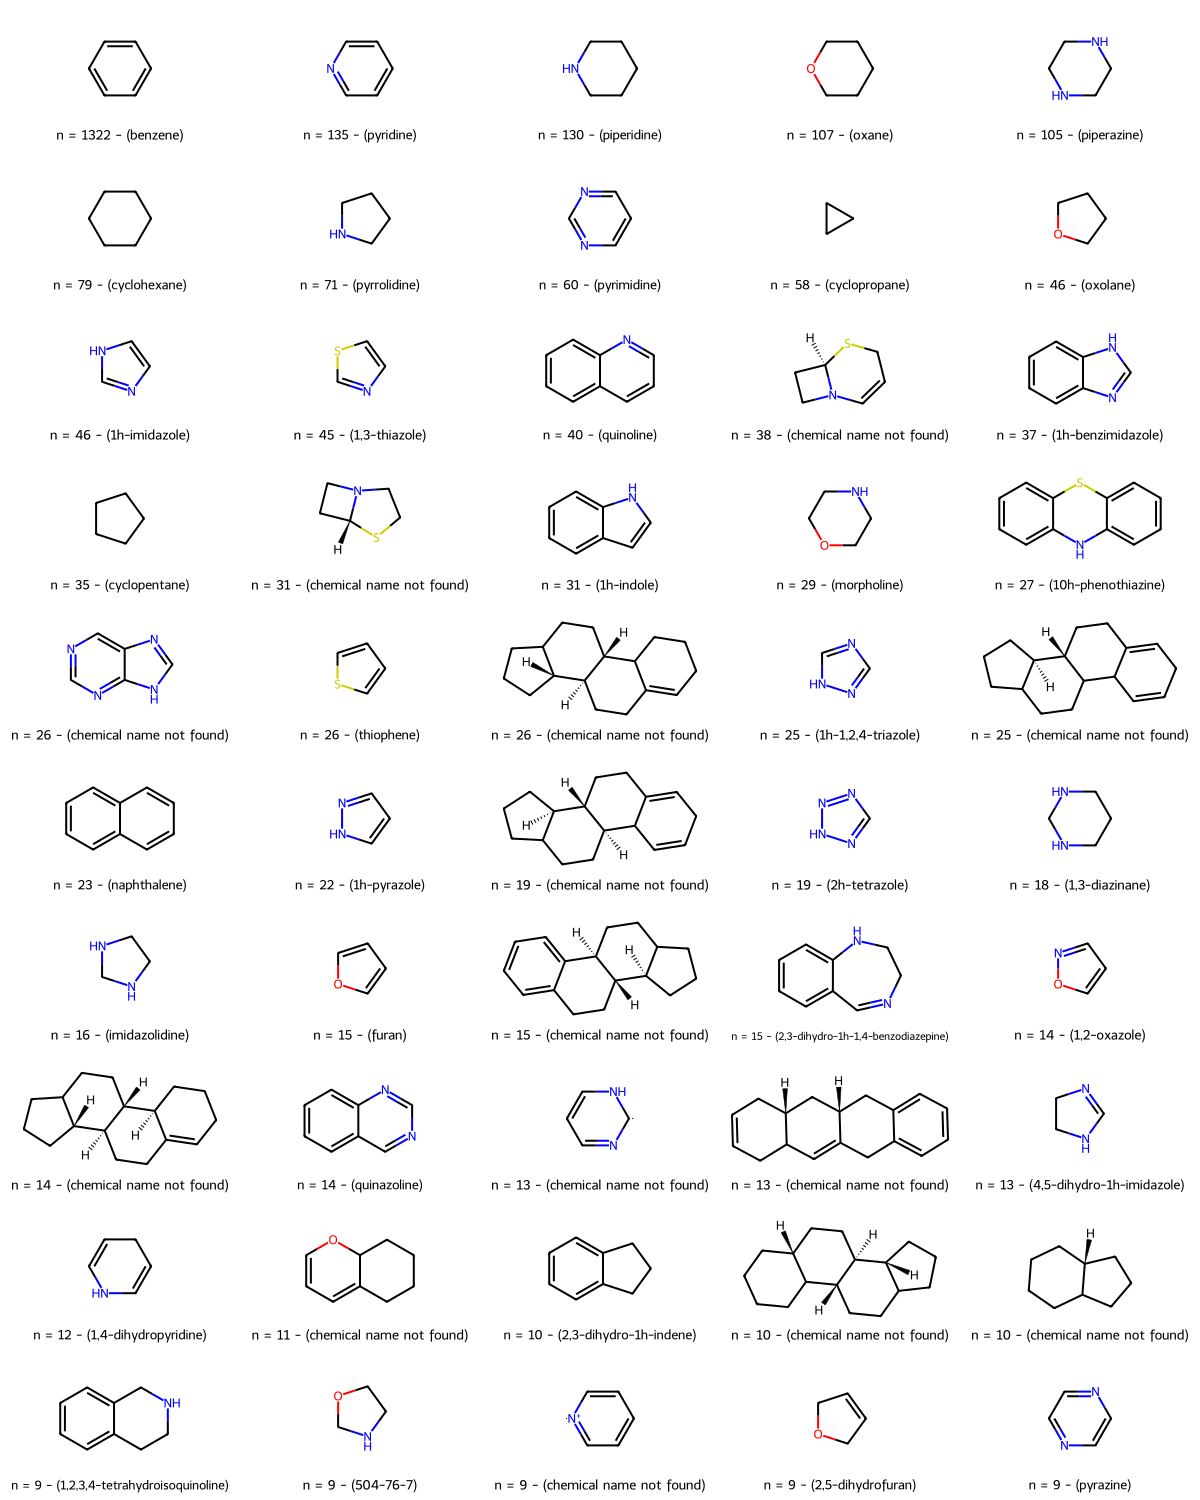

In [52]:
mol_rings = [Chem.MolFromSmiles(SMILES) for SMILES in list(rings_df.SMILES)[0:50]]
legends = [f'n = {str(number)} - ({str(name)})' for number, name in zip(list(legends_df.n),list(legends_df.SMILES))]
d = Draw.MolsToGridImage(mol_rings, molsPerRow = 5,legends=legends, maxMols=300, subImgSize=(240,150))
d

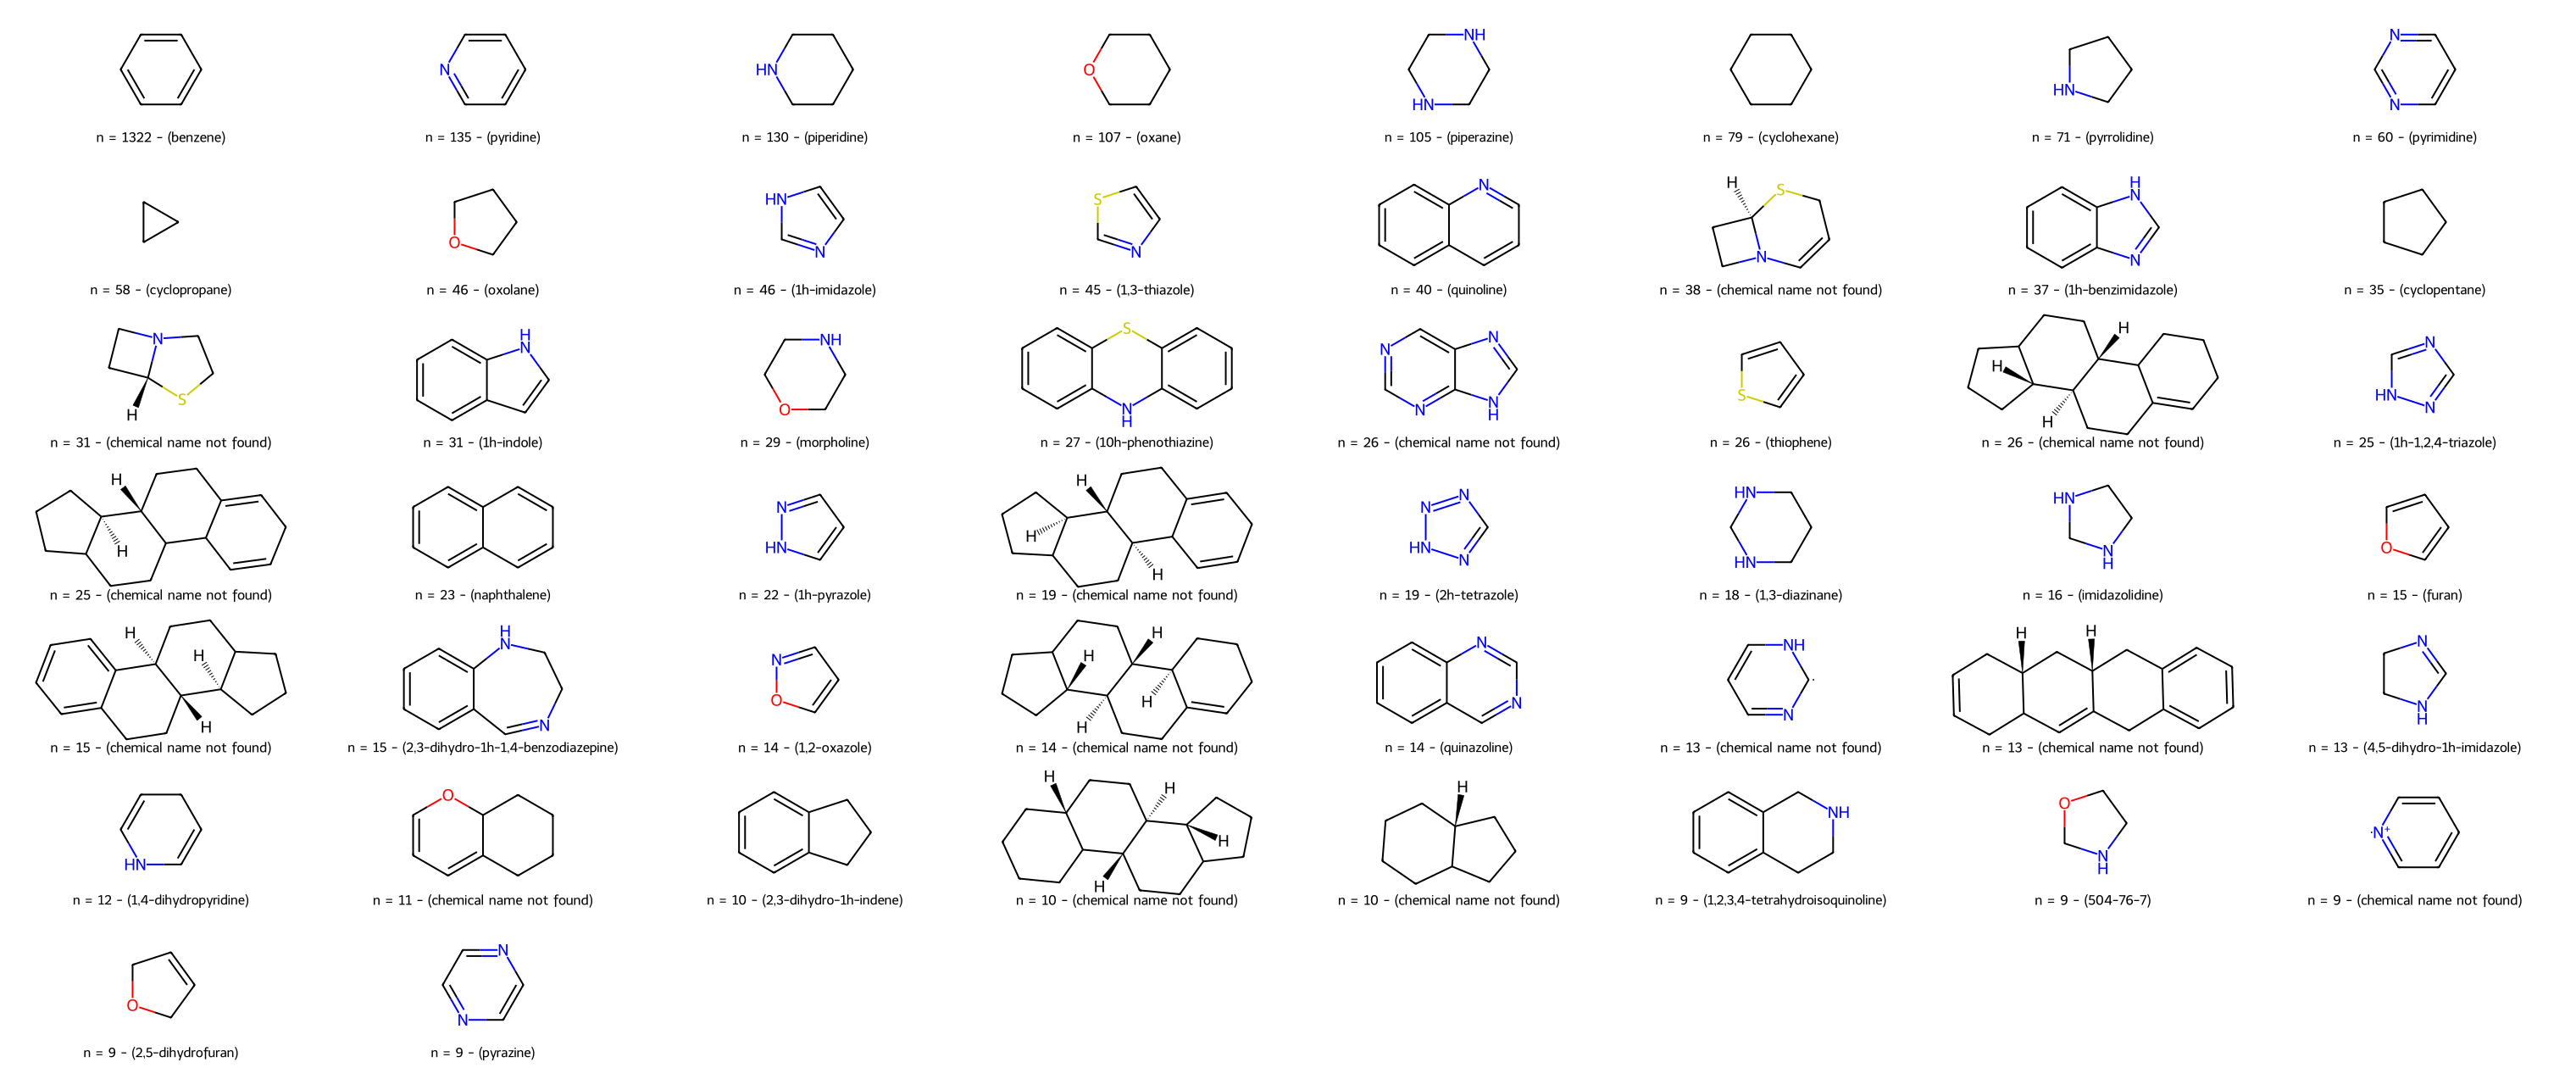

In [64]:
# for the slides
legends = [f'n = {str(number)} - ({str(name)})' for number, name in zip(list(legends_df.n),list(legends_df.SMILES))]
d = Draw.MolsToGridImage(mol_rings, molsPerRow = 8,legends=legends, maxMols=300, subImgSize=(380,180))
d